In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense
from nltk.stem import PorterStemmer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [2]:
# Specify column names
column_names = ['Review', 'Label']

# Read in txt files and set column headers
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Amazon shape: {amazon.shape}')
imdb = pd.read_csv('imdb_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'IMDB shape: {imdb.shape}')
yelp = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Yelp shape: {yelp.shape}')

Amazon shape: (1000, 2)
IMDB shape: (748, 2)
Yelp shape: (1000, 2)


In [3]:
# Concatenate the three dataframes together
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

In [4]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  2748 non-null   object
 1   Label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [5]:
# Check Label to make sure values look appropriate
df['Label'].value_counts(dropna=False)

Label
1    1386
0    1362
Name: count, dtype: int64

# Applying Lowercase and Remove Punctuation

In [6]:
# Using Regex to search for special characters (Python, 2024)
# Regex pattern for special characters excluding punctuation
pattern = r'[^A-Za-z0-9\s\.,!?;:\-\'\"()]'

# Search using Regex pattern
mask = df['Review'].str.contains(pattern, regex=True)

# Filter using mask to show rows with special characters
special_char_rows = df[mask]
special_char_rows

,Review,Label
12,If the two were seperated by a mere 5+ ft I st...,0
25,Great Pocket PC / phone combination.,1
132,Headset works great & was packaged nicely to a...,1
154,I've bought $5 wired headphones that sound bet...,0
156,"Nice quality build, unlike some cheap s*** out...",1
...,...,...
2626,"I love the owner/chef, his one authentic Japan...",1
2663,The only thing I wasn't too crazy about was th...,0
2684,The sangria was about half of a glass wine ful...,0
2733,The problem I have is that they charge $11.99 ...,0


In [7]:
print('Before any preprocessing:')
print(df['Review'].iloc[12])
print()

# Set 'Review' to lowercase
df['Review'] = df['Review'].str.lower()

print('After applying lowercase:')
print(df['Review'].iloc[12])
print()

# Remove special characters and punctuation (Python, 2024)
pattern = r'[^\w\s]'
df['Review'] = df['Review'].str.replace(pattern, '', regex=True)

print('After removing punctuation:')
print(df['Review'].iloc[12])

Before any preprocessing:
If the two were seperated by a mere 5+ ft I started to notice excessive static and garbled sound from the headset.

After applying lowercase:
if the two were seperated by a mere 5+ ft i started to notice excessive static and garbled sound from the headset.

After removing punctuation:
if the two were seperated by a mere 5 ft i started to notice excessive static and garbled sound from the headset


# Tokenization and Stop words

In [8]:
# Apply Tokenization and remove stop words (Sewell, Web6)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


print('Before tokenizing and applying stopwords:')
print(df['Review'].iloc[12])
print()

# Download stop word list
stop_words = set(stopwords.words('english'))

# Create empty list
data_set = []

# Tokenize and remove stop words
for sentence in df['Review']:
    data_set.append([word for word in word_tokenize(sentence) if word not in stop_words])

# Assign list back to dataframe
df['Review'] = data_set

print('After tokenizing and applying stopwords:')
print(df['Review'].iloc[12])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Before tokenizing and applying stopwords:
if the two were seperated by a mere 5 ft i started to notice excessive static and garbled sound from the headset

After tokenizing and applying stopwords:
['two', 'seperated', 'mere', '5', 'ft', 'started', 'notice', 'excessive', 'static', 'garbled', 'sound', 'headset']


# Apply Stemming

In [9]:
# Apply Stemming (GeeksforGeeks, 2023)

print('Before Stemming:')
print(df['Review'].iloc[12])
print()

# Initialize PorterStemmer object
stemmer = PorterStemmer()

# Create a function to stem tokenized text
def stem_tokens(token_list):
    return [stemmer.stem(word) for word in token_list]

# Apply the function
df['Review'] = df['Review'].apply(stem_tokens)

print('After Stemming:')
print(df['Review'].iloc[12])

Before Stemming:
['two', 'seperated', 'mere', '5', 'ft', 'started', 'notice', 'excessive', 'static', 'garbled', 'sound', 'headset']

After Stemming:
['two', 'seper', 'mere', '5', 'ft', 'start', 'notic', 'excess', 'static', 'garbl', 'sound', 'headset']


# Determine Vocabulary Size and Vectorization

In [10]:
# Vectorization (Sewell, Web6)
print('Before vectorizing for model:')
print(df['Review'].iloc[12])
print()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

print('After vectorizing for model:')
print(sequences[12])
print()

Before vectorizing for model:
['two', 'seper', 'mere', '5', 'ft', 'start', 'notic', 'excess', 'static', 'garbl', 'sound', 'headset']

After vectorizing for model:
[75, 1261, 1844, 231, 1845, 187, 763, 1262, 970, 1846, 41, 40]



In [11]:
# Get the word index and word counts
word_index = tokenizer.word_index

# The vocabulary size is the length of the word_index
vocab_size = len(word_index) + 1
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 4177


# Determine Max Length For Padding

count    2748.000000
mean        6.857715
std        20.398946
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       789.000000
dtype: float64


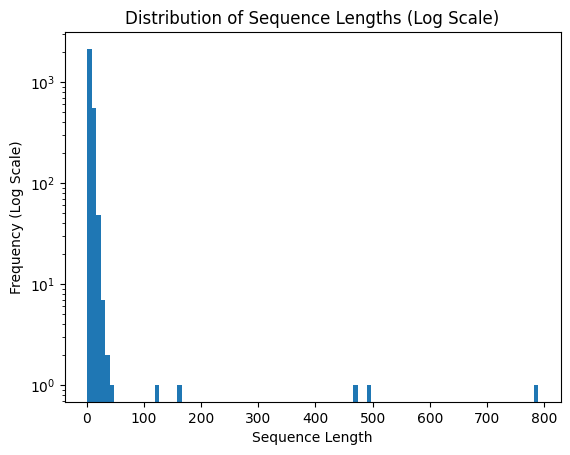

In [12]:
# Calculate the lengths of the sequences
lengths = [len(seq) for seq in sequences]

# Describe the lengths
lengths_series = pd.Series(lengths)
print(lengths_series.describe())

# Plot the distribution of sequence lengths
plt.hist(lengths, bins=100, log=True)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Sequence Lengths (Log Scale)')
plt.show()

In [13]:
# Calculate the max_length using the 95th percentile
max_length = int(np.percentile(lengths, 95))
print(f'Max Sequence Length at 95th Percentile: {max_length}')

Max Sequence Length at 95th Percentile: 14


# Apply Padding

In [14]:
# Pad Sequences (Sewell, Web6)
print('Before padding:')
print(sequences[0])
print()

X = pad_sequences(sequences, maxlen = max_length, padding='post')

print('After padding:')
print(X[0])

Before padding:
[52, 230, 120, 566, 17, 1839]

After padding:
[  52  230  120  566   17 1839    0    0    0    0    0    0    0    0]


# Define Labels and Split Data

In [15]:
y = df['Label'].values

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

In [21]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Setting the embedding vector length to 32
embedding_vector_length = 32

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vector_length))
#model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
# Consider starting with a lower learning rate if training is unstable
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5016 - loss: 7.2484 - val_accuracy: 0.5091 - val_loss: 6.8565
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4743 - loss: 6.9770 - val_accuracy: 0.5068 - val_loss: 6.6249
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4843 - loss: 6.7171 - val_accuracy: 0.5068 - val_loss: 6.4036
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5087 - loss: 6.4690 - val_accuracy: 0.5068 - val_loss: 6.1913
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5255 - loss: 6.2344 - val_accuracy: 0.5068 - val_loss: 5.9878
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5001 - loss: 6.0396 - val_accuracy: 0.5068 - val_loss: 5.7933
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5371 - loss: 5.8321 - val_accuracy: 0.5068 - val_loss: 5.6069
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4953 - loss: 5.6603 - val_accuracy: 0.5068 - v

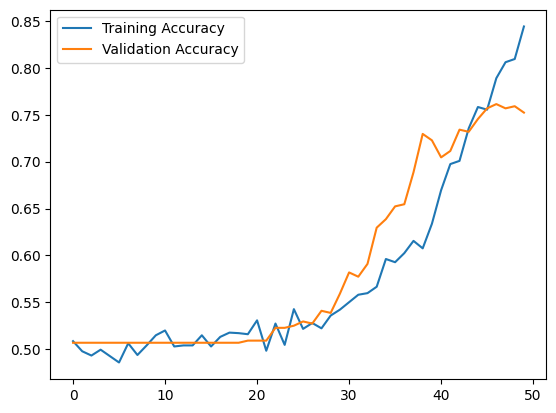

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

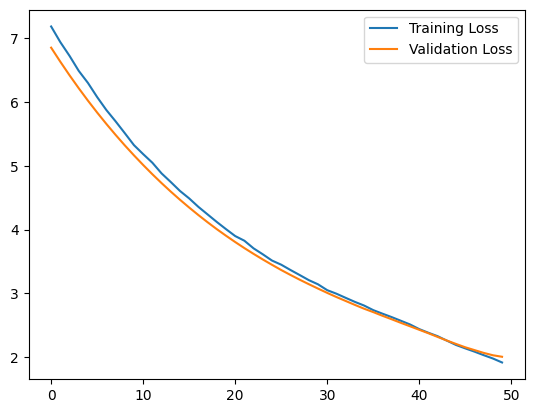

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [20]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 14, 32)              │         133,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 14, 200)             │         106,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 200)             │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,049,525 (4.00 MB)

 Trainable params: 349,641 (1.33 MB)

 Non-trainable params: 600 (2.34 KB)

 Optimizer params: 699,284 (2.67 MB)

None
